# Plotting of scRNA-seq signal  

Author: Daniel Levings  
Date: 2022-06-29  

This is the second of two **Jupyter Notebooks** created to document my comparison of a mouse brain snATAC-seq (single nuclei assay for transposase accessible chromatin with sequencing) data set from 
[CATlas](http://catlas.org/mousebrain/) with a scRNA-seq (single cell RNA sequencing) data set from the Linnarsson lab's [Mouse brain atlas](http://mousebrain.org/).  Specifically, in this code, I identify differences in neuronal vs other cell types in the mouse brain based on gene expression (scRNA-seq signal aggregated by cell type/cluster).  

Datasets accompany the following papers:  

[Li, Y.E., Preissl, S., Hou, X. et al. An atlas of gene regulatory elements in adult mouse](https://doi.org/10.1038/s41586-021-03604-1)  
[cerebrum. (2021). *Nature* 598, 129–136. https://doi.org/10.1038/s41586-021-03604-1](https://doi.org/10.1038/s41586-021-03604-1)  

[La Manno, G., Siletti, K., Furlan, A., et al. Molecular architecture of the developing](https://doi.org/10.1038/s41586-021-03775-x)  
[mouse brain. Nature. 2021 Aug;596(7870):92-96. Epub 2021 Jul 28.](https://doi.org/10.1038/s41586-021-03775-x])  
[https://doi.org/10.1038/s41586-021-03775-x](https://doi.org/10.1038/s41586-021-03775-x])  

<br>

## Set up environment  

First import relevant *Python* modules.  If not installed, please install the following with *pip* or *conda*:  

- *numpy*  
- *pandas*  
- *loompy*  
- *matplotlib*  
- *plotnine*  

In [1]:
import os
import sys
import requests
import itertools
from datetime import date
import numpy as np
import pandas as pd
import loompy
import plotnine as p9
from matplotlib import rc
%matplotlib inline

<br>

Now check the currently loaded environment:

In [2]:
print(sys.version_info)
modulenames = set(sys.modules) & set(globals())
print(modulenames)
del(modulenames)

sys.version_info(major=3, minor=9, micro=13, releaselevel='final', serial=0)
{'itertools', 'requests', 'sys', 'loompy', 'os'}


<br>

## Download and import the data  

Download the scRNA-seq data for adolescent brain from Linnarsson lab's [Mouse brain atlas](http://mousebrain.org/adolescent/).  [Loompy.org](http://loompy.org) has more detailed information on the file format specifications (Loom files) as well as how to use various API to access these files.  

In [3]:
URL = "https://storage.googleapis.com/linnarsson-lab-loom/l5_all.agg.loom"
response = requests.get(URL)
open("l5_all.agg.loom", "wb").write(response.content)

114859798

In [4]:
# Check to make sure it's in current directory
os.listdir()

['.ipynb_checkpoints',
 'Mouse-brain-CATlas_celltype-clustering.pdf',
 'Mouse-brain-atlas_cell-expr-signal.ipynb',
 'l5_all.agg.loom',
 'bigwigs',
 'Mouse-brain-atlas_cell-expr-signal.pdf',
 'Mouse-brain-CATlas_celltype-clustering.ipynb',
 'Cell annotation.xlsx']

Import the data using *loompy*.  

In [5]:
mba = loompy.connect("l5_all.agg.loom")

<br>

Check the data/make sure it was imported properly.  

In [6]:
mba[0:6, 0:6]

array([[13.97633136,  0.42268041,  0.12711864,  0.08494208,  0.03870968,
         0.        ],
       [ 0.39053254,  0.        ,  0.        ,  0.        ,  0.        ,
         0.03225806],
       [ 7.60946746,  1.3814433 ,  0.18644068,  0.51737452,  0.41290323,
         1.32258065],
       [ 0.92899408,  0.09278351,  0.19491525,  0.12741313,  0.1483871 ,
         0.19354839],
       [ 8.73964497,  9.        ,  3.60169492,  1.75289575,  1.10322581,
         1.87096774],
       [ 1.59763314,  0.22680412,  0.04237288,  0.05405405,  0.03225806,
         0.29032258]])

In [7]:
mba.shape

(27998, 265)

<br>

Check what kind of gene-level (row) information can be accessed.  

In [55]:
mba.ra.keys()

['Accession', 'Gene', '_LogCV', '_LogMean', '_Selected', '_Total', '_Valid']

Now, check what kind of sample-level (column) information can be accessed.  

In [56]:
tmp_list = []
idx = list(itertools.chain.from_iterable([[0,1,2,3],[*range(22,42)],[200,201,202],[*range(190,214)]]))
for i in range(len(mba.ca.keys())):
    if any(i == j for j in idx):
        tmp_list.append(mba.ca.keys()[i])
print(tmp_list)
del(i, idx, tmp_list)

['Age_6w', 'Age_?', 'Age_p12, p35', 'Age_p16, p24', 'Bucket', 'Class', 'ClusterName', 'ClusterScore', 'Clusters', 'Comment', 'Description', 'Developmental_compartment', 'LeafOrder', 'Location_based_on', 'MarkerGenes', 'MarkerRobustness', 'MarkerSelectivity', 'MarkerSpecificity', 'NCells', 'Neurotransmitter', 'OriginalClusters', 'Outliers', 'Probable_location', 'Region', 'Tissue_Amygd', 'Tissue_CA1', 'Tissue_CB', 'Tissue_Ctx1', 'Tissue_Ctx1.5', 'Tissue_Ctx2', 'Tissue_Ctx3', 'Tissue_DRG', 'Tissue_DentGyr', 'Tissue_ENS', 'Tissue_HC', 'Tissue_Hypoth', 'Tissue_MBd', 'Tissue_MBv', 'Tissue_Medulla', 'Tissue_OB', 'Tissue_Pons', 'Tissue_SC', 'Tissue_SScortex', 'Tissue_StriatDor', 'Tissue_StriatVent', 'Tissue_Sympath', 'Tissue_Thal', '_Total']


<br>

Now import the gene-level and sample-level data of interest into list objects, and the actual gene-by-cluster (scRNA-seq data aggregated by cluster/cell-type) expression matrix into a *pandas* data frame.  

In [9]:
# Get basic cell types/classes
agg_Class = mba.ca.Class.astype('U')

# Get the clusters
agg_Clusters = mba.ca.Clusters
agg_ClusterName = mba.ca.ClusterName.astype('U')

# Get number of cells per cluster
agg_NCells = mba.ca.NCells

# Get other possibly useful info: description for each cell, 
# OriginalClusters, region and outliers
agg_Description = mba.ca.Description.astype('U')
agg_OriginalClusters = mba.ca.OriginalClusters
agg_Region = mba.ca.Region.astype('U')

# Now download row attributes- gene names, etc
agg_row_ENSMUSG = mba.ra.Accession.astype('U')
agg_row_GeneName = mba.ra.Gene.astype('U')
agg_row_Total = mba.ra._Total
agg_row_Selected = mba.ra._Selected
agg_row_LogCV = mba.ra._LogCV
agg_row_LogMean = mba.ra._LogMean

# Now, convert the dataset array and these data into dataframes
expr_df = pd.DataFrame(mba[:,:], index = agg_row_ENSMUSG, columns = agg_ClusterName)

<br>

Check data (overall size) and sample.  

In [10]:
expr_df.shape

(27998, 265)

In [11]:
expr_df.iloc[0:6, 0:6]

,ENT9,ENT8,ENT6,ENT5,ENT4,ENT7
ENSMUSG00000024647,13.976331,0.422680,0.127119,0.084942,0.038710,0.000000
ENSMUSG00000041544,0.390533,0.000000,0.000000,0.000000,0.000000,0.032258
ENSMUSG00000029503,7.609467,1.381443,0.186441,0.517375,0.412903,1.322581
ENSMUSG00000039942,0.928994,0.092784,0.194915,0.127413,0.148387,0.193548
ENSMUSG00000059187,8.739645,9.000000,3.601695,1.752896,1.103226,1.870968
ENSMUSG00000017756,1.597633,0.226804,0.042373,0.054054,0.032258,0.290323


<br>

Finally, make 2 data frames, one with all the cluster/cell-type data and one with all the gene-level data.  

In [12]:
col_df = pd.DataFrame({"Cluster_Name" : agg_ClusterName, "Cluster" : agg_Clusters, 
    "Class" : agg_Class, "Description" : agg_Description, "Region" : agg_Region, 
    "Number_of_cells" : agg_NCells})

In [13]:
row_df = pd.DataFrame({"ENSMUSG" : agg_row_ENSMUSG, "Gene_symbol" : agg_row_GeneName, 
    "LogCV" : agg_row_LogCV, "LogMean" : agg_row_LogMean, "Selected" : agg_row_Selected,
    "Total" : agg_row_Total})

<br>

## Extract *Nsg2* and make plotting data frame  

Identify the row corresponding to the gene *Neuron-specific gene 2* (*Nsg2*), and pull the expression data.  

In [14]:
Nsg2_idx = int(np.transpose(np.where(agg_row_GeneName == "Nsg2")))

In [15]:
row_df.iloc[Nsg2_idx, :]

ENSMUSG        ENSMUSG00000020297
Gene_symbol                  Nsg2
LogCV                    0.802589
LogMean                  0.881825
Selected                        0
Total                      2589.0
Name: 15421, dtype: object

In [16]:
expr_df.iloc[Nsg2_idx, 0:6]

ENT9    10.550296
ENT8     9.030928
ENT6     4.813559
ENT5     2.467181
ENT4     2.993548
ENT7     5.645161
Name: ENSMUSG00000020297, dtype: float64

<br>

Combine  expression data with the cluster/cell type-level data.  

In [17]:
plotting_df = pd.concat([pd.DataFrame({"expression" : expr_df.iloc[Nsg2_idx,:].to_numpy()}),
    col_df], axis = 1, ignore_index=False) 

Check the basic cell types annotated in this data set.  

In [18]:
pd.unique(plotting_df["Class"])

array(['Neurons', 'PeripheralGlia', 'Vascular', 'Oligos', 'Astrocytes',
       'Ependymal', 'Immune'], dtype=object)

Now, make basic cell classes even more simple: separate into neuron and non-neuron (broadly called 'support') cells.  Add this classification back to $plotting\_df$.  

In [19]:
basic_class=[]
for i in plotting_df["Class"]:
    if(i == "Neurons"):
        basic_class.append("Neuron")
    else:
        basic_class.append("Support")

plotting_df["Basic class"] = basic_class

Check $plotting\_df$ sample.  

In [20]:
plotting_df.head()

,expression,Cluster_Name,Cluster,Class,Description,Region,Number_of_cells,Basic class
0,10.550296,ENT9,0,Neurons,Cholinergic enteric neurons,Enteric nervous system,169,Neuron
1,9.030928,ENT8,1,Neurons,"Cholinergic enteric neurons, VGLUT2",Enteric nervous system,97,Neuron
2,4.813559,ENT6,2,Neurons,Cholinergic enteric neurons,Enteric nervous system,118,Neuron
3,2.467181,ENT5,3,Neurons,Cholinergic enteric neurons,Enteric nervous system,259,Neuron
4,2.993548,ENT4,4,Neurons,Cholinergic enteric neurons,Enteric nervous system,155,Neuron


<br>

Now, summarize the expression data by the new basic cell classes I designated.  Specifically, calculate the median and mean expression in each of these basic cell classes.  

In [22]:
summ_df = plotting_df.drop(['Cluster_Name', 'Cluster', 'Class', 'Region', 'Description'], axis = 1).groupby(['Basic class'], axis = 0, ).agg(['mean','median'])

Flatten the summarized data so I have a 'simple' data frame again (and reset index).  Then check the summarized values.  

In [23]:
summ_df.columns = ['_'.join(col) for col in summ_df.columns.values]
summ_df.reset_index(inplace = True)

In [24]:
summ_df

,Basic class,expression_mean,expression_median,Number_of_cells_mean,Number_of_cells_median
0,Neuron,3.546293,2.871154,348.313084,137.5
1,Support,0.239595,0.041005,1691.313725,1025.0


<br>

## Plot *Nsg2* expression using *plotnine*  

First, set up the theme/aesthetics I want to use for my plot in *plotnine*.  

In [25]:
p9.themes.theme_set(p9.theme_bw(base_family = "Arial") + 
    p9.theme(plot_title = p9.element_text(ha="center", va="baseline", 
            size = 14, margin = {'t' : 5, 'b' : 0, 'l' : 5, 'r' : 5}), 
        axis_text = p9.element_text(color="black", size = 11), 
        axis_title = p9.element_text(color="black", size = 12), 
        axis_ticks = p9.element_line(color="black"), 
        legend_title = p9.element_text(face = "italic", size = 12),
        legend_text = p9.element_text(size = 11),
        panel_border = p9.element_rect(size=0.75, color="black"), 
        legend_position = "right",
        panel_grid_major = p9.element_line(color = "silver", linetype="solid", size=0.2),
        panel_grid_minor = p9.element_line(color = "silver", linetype="dashed", size=0.1)
    ))

<br>

Now use *plotnine* to generate a 'dot-plot' where the dots are constrained within a 'violin plot-like' object to show the distribution of the data for each group.  This is called a *sina* plot.  Also, I will color by the basic (but more specific that what I annotated) cell types given with the data.  

/home/daniel/anaconda3/envs/loompy/lib/python3.9/site-packages/plotnine/positions/position.py:204: PlotnineWarning: position_dodge requires non-overlapping x intervals


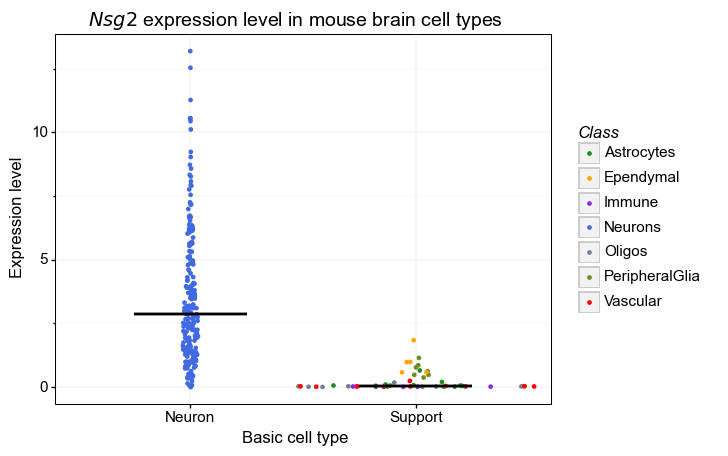

<ggplot: (8790027644938)>

In [32]:
# make plot

Nsg2_expr_plot = (
    p9.ggplot(data = plotting_df, mapping = p9.aes(x="Basic class", y="expression")) + 
    p9.geom_sina(mapping = p9.aes(group = "Basic class", color = "Class"), maxwidth = 1.1, size = 0.9,
        method = "density", scale = "area") + 
    p9.scales.scale_color_manual(values = ({'Neurons' : "royalblue", 'PeripheralGlia' : "olivedrab", 
       'Vascular' : "red", 'Oligos' : "slategrey", 'Astrocytes' : "forestgreen",
       'Ependymal' : "orange", 'Immune' : "blueviolet"})) +
    p9.labs(x = "Basic cell type", y = "Expression level", 
        title = "$Nsg2$ expression level in mouse brain cell types") +
    p9.geom_errorbar(data = summ_df, inherit_aes = False, size = 1,
        mapping = p9.aes(x="Basic class", ymin="expression_median", ymax="expression_median"))
    )

# output
Nsg2_expr_plot

<br>

If you want to save this plot to it's own PDF file, uncomment the next lines and run:  

In [27]:
# Nsg2_expr_plot.save(filename = "Nsg2-scRNAseq-expression-levels_Mouse-brain-atlas.pdf",
#                     format = "pdf", width = 7, height = 5.5, units = "in", dpi = 250)

Wrap up by closing the *loompy* object.  

In [28]:
mba.close()